In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['F14.csv']


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("../input/F14.csv")

In [4]:
data.head()

,Unnamed: 0,index,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,DP_CHOKE_SIZE,AVG_WHP_P,AVG_WHT_P,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
0,0,5118,24.00,260.866875,103.292880,160.151955,21.052993,69.539413,100.714919,52.381899,1735.26,252235.23,14.00
1,1,5119,5.57,256.248230,104.017718,156.649912,27.223459,68.016167,99.598318,71.115352,592.36,88949.00,11.37
2,2,5120,24.00,254.982785,103.967009,156.332844,27.277954,66.948884,98.649941,67.590753,2532.21,373786.28,15.84
3,3,5121,24.00,251.475921,104.210557,155.817187,30.650552,63.663812,95.658734,73.782251,3030.71,447840.09,19.13
4,4,5122,24.00,249.346191,104.339184,155.760939,32.562537,61.337700,93.585252,78.035440,3288.08,474614.43,17.58


In [5]:
data.drop('Unnamed: 0', axis  =1, inplace = True)

In [6]:
data.drop('index', axis = 1, inplace =True)

In [7]:
data.head(20)

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,DP_CHOKE_SIZE,AVG_WHP_P,AVG_WHT_P,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
0,24.00,260.866875,103.292880,160.151955,21.052993,69.539413,100.714919,52.381899,1735.26,252235.23,14.00
1,5.57,256.248230,104.017718,156.649912,27.223459,68.016167,99.598318,71.115352,592.36,88949.00,11.37
2,24.00,254.982785,103.967009,156.332844,27.277954,66.948884,98.649941,67.590753,2532.21,373786.28,15.84
3,24.00,251.475921,104.210557,155.817187,30.650552,63.663812,95.658734,73.782251,3030.71,447840.09,19.13
4,24.00,249.346191,104.339184,155.760939,32.562537,61.337700,93.585252,78.035440,3288.08,474614.43,17.58
5,24.00,251.501571,104.333687,155.278797,30.051586,64.305031,96.222774,75.749887,2780.06,410359.82,21.05
6,24.00,251.508943,104.353860,155.359876,30.083934,64.164310,96.149067,75.335040,2774.38,420865.05,16.40
7,24.00,251.457711,104.378397,155.351759,30.117950,64.128160,96.105952,75.616605,2791.01,408766.41,16.43
8,24.00,251.724326,104.398653,155.234376,29.830638,64.560483,96.489950,76.077794,2743.10,402199.56,16.32
9,24.00,251.858368,104.407234,155.172133,29.748209,64.770177,96.686235,77.017105,2717.44,399221.04,16.45


In [8]:
from __future__ import division
#import pandas as pd
import keras
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.utils import plot_model

Using TensorFlow backend.


In [9]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

In [10]:
df = data

In [11]:
test_fraction = 0.15
X = df[['ON_STREAM_HRS','AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
        'AVG_DP_TUBING', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P','DP_CHOKE_SIZE', 'AVG_WHT_P']]
#X = df[[ 'AVG_WHP_P', 'AVG_CHOKE_SIZE_P']]
#X = df[['AVG_DOWNHOLE_PRESSURE', 'AVG_WHP_P']]
Y = df[['BORE_OIL_VOL', 'BORE_GAS_VOL','BORE_WAT_VOL']]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = test_fraction, shuffle = False)
val_fraction = 0.15
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train,
                                                  test_size = val_fraction/(1-test_fraction), shuffle = False)

In [13]:
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train.as_matrix())
x_val_norm = scaler_x.transform(x_val.as_matrix())
x_test_norm = scaler_x.transform(X_test.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train.as_matrix())
y_val_norm = scaler_y.transform(y_val.as_matrix())
y_test_norm = scaler_y.transform(Y_test.as_matrix())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Metho

In [14]:
# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=35)
x_val, y_val = create_timeblock(x_val_norm, y_val_norm, look_back=35)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=35)

# of data:  1870
# of data:  374
# of data:  374


In [15]:
def run_model(x_train, y_train, x_val, y_val, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}


    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    X = classifier[method](512, return_sequences=True)(X)
    #X = classifier[method](256, return_sequences=True)(X)
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(input=inputs, output=[out1, out2, out3])
    #opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.001)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer= opt, metrics=['mae'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, [y_val[:, 0], y_val[:, 1], y_val[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [16]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_val, y_val, epochs=300, batch_size=400, method='LSTM')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Instructions for updating:
Use tf.cast instead.
Train on 1870 samples, validate on 374 samples
Epoch 1/300
1870/1870 [==============================] - 6s 3ms/step - loss: 0.6750 - dense_2_loss: 0.2977 - dense_3_loss: 0.2716 - dense_4_loss: 0.1057 - dense_2_mean_absolute_error: 0.4338 - dense_3_mean_absolute_error: 0.4346 - dense_4_mean_absolute_error: 0.2465 - val_loss: 0.0524 - val_dense_2_loss: 4.0299e-04 - val_dense_3_loss: 0.0022 - val_dense_4_loss: 0.0498 - val_dense_2_mean_absolute_error: 0.0174 - val_dense_3_mean_absolute_error: 0.0439 - val_dense_4_mean_absolute_error: 0.2174
Epoch 2/300
1870/1870 [==============================] - 1s 797us/step - loss: 0.3397 - dense_2_loss: 0.1180 - dense_3_loss: 0.1204 - dense_4_loss: 0.1012 - dense_2_mean_absolute_error: 0.2855 - dense_3_mean_absolute_error: 0.2804 - dense_4_mean_absolute_error: 0.2722 - val_loss: 0.0121 - val_dense_2_loss: 6.5409e-04 - val_dense_3_loss: 0.0058 - val_dense_4_loss: 0.0056 - val_dense_2_mean_absolute_error: 

Epoch 17/300
1870/1870 [==============================] - 1s 802us/step - loss: 0.0573 - dense_2_loss: 0.0178 - dense_3_loss: 0.0189 - dense_4_loss: 0.0206 - dense_2_mean_absolute_error: 0.0941 - dense_3_mean_absolute_error: 0.1001 - dense_4_mean_absolute_error: 0.1087 - val_loss: 0.0243 - val_dense_2_loss: 0.0073 - val_dense_3_loss: 0.0115 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0845 - val_dense_3_mean_absolute_error: 0.1064 - val_dense_4_mean_absolute_error: 0.0403
Epoch 18/300
1870/1870 [==============================] - 1s 801us/step - loss: 0.0548 - dense_2_loss: 0.0163 - dense_3_loss: 0.0170 - dense_4_loss: 0.0215 - dense_2_mean_absolute_error: 0.0913 - dense_3_mean_absolute_error: 0.0946 - dense_4_mean_absolute_error: 0.1120 - val_loss: 0.0181 - val_dense_2_loss: 0.0049 - val_dense_3_loss: 0.0075 - val_dense_4_loss: 0.0057 - val_dense_2_mean_absolute_error: 0.0692 - val_dense_3_mean_absolute_error: 0.0852 - val_dense_4_mean_absolute_error: 0.0414
Epoch 19

1870/1870 [==============================] - 1s 785us/step - loss: 0.0657 - dense_2_loss: 0.0209 - dense_3_loss: 0.0222 - dense_4_loss: 0.0225 - dense_2_mean_absolute_error: 0.0968 - dense_3_mean_absolute_error: 0.1016 - dense_4_mean_absolute_error: 0.1153 - val_loss: 0.0132 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 0.0026 - val_dense_4_loss: 0.0093 - val_dense_2_mean_absolute_error: 0.0345 - val_dense_3_mean_absolute_error: 0.0493 - val_dense_4_mean_absolute_error: 0.0666
Epoch 34/300
1870/1870 [==============================] - 1s 786us/step - loss: 0.0772 - dense_2_loss: 0.0292 - dense_3_loss: 0.0297 - dense_4_loss: 0.0183 - dense_2_mean_absolute_error: 0.1282 - dense_3_mean_absolute_error: 0.1317 - dense_4_mean_absolute_error: 0.1002 - val_loss: 0.0166 - val_dense_2_loss: 0.0049 - val_dense_3_loss: 0.0061 - val_dense_4_loss: 0.0056 - val_dense_2_mean_absolute_error: 0.0693 - val_dense_3_mean_absolute_error: 0.0771 - val_dense_4_mean_absolute_error: 0.0471
Epoch 35/300
1870/187

1870/1870 [==============================] - 1s 791us/step - loss: 0.0511 - dense_2_loss: 0.0145 - dense_3_loss: 0.0149 - dense_4_loss: 0.0218 - dense_2_mean_absolute_error: 0.0776 - dense_3_mean_absolute_error: 0.0788 - dense_4_mean_absolute_error: 0.1143 - val_loss: 0.0071 - val_dense_2_loss: 7.7808e-04 - val_dense_3_loss: 8.3021e-04 - val_dense_4_loss: 0.0055 - val_dense_2_mean_absolute_error: 0.0266 - val_dense_3_mean_absolute_error: 0.0274 - val_dense_4_mean_absolute_error: 0.0436
Epoch 50/300
1870/1870 [==============================] - 1s 782us/step - loss: 0.0558 - dense_2_loss: 0.0175 - dense_3_loss: 0.0185 - dense_4_loss: 0.0197 - dense_2_mean_absolute_error: 0.1005 - dense_3_mean_absolute_error: 0.1040 - dense_4_mean_absolute_error: 0.1061 - val_loss: 0.0166 - val_dense_2_loss: 0.0046 - val_dense_3_loss: 0.0059 - val_dense_4_loss: 0.0060 - val_dense_2_mean_absolute_error: 0.0674 - val_dense_3_mean_absolute_error: 0.0762 - val_dense_4_mean_absolute_error: 0.0521
Epoch 51/300


1870/1870 [==============================] - 1s 785us/step - loss: 0.0471 - dense_2_loss: 0.0143 - dense_3_loss: 0.0152 - dense_4_loss: 0.0176 - dense_2_mean_absolute_error: 0.0786 - dense_3_mean_absolute_error: 0.0827 - dense_4_mean_absolute_error: 0.0961 - val_loss: 0.0065 - val_dense_2_loss: 5.8105e-04 - val_dense_3_loss: 4.5444e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0219 - val_dense_3_mean_absolute_error: 0.0186 - val_dense_4_mean_absolute_error: 0.0405
Epoch 66/300
1870/1870 [==============================] - 1s 789us/step - loss: 0.0478 - dense_2_loss: 0.0141 - dense_3_loss: 0.0153 - dense_4_loss: 0.0184 - dense_2_mean_absolute_error: 0.0824 - dense_3_mean_absolute_error: 0.0858 - dense_4_mean_absolute_error: 0.1005 - val_loss: 0.0057 - val_dense_2_loss: 1.1639e-04 - val_dense_3_loss: 1.3692e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0073 - val_dense_3_mean_absolute_error: 0.0078 - val_dense_4_mean_absolute_error: 0.0405
Epoch

1870/1870 [==============================] - 1s 792us/step - loss: 0.0533 - dense_2_loss: 0.0141 - dense_3_loss: 0.0147 - dense_4_loss: 0.0245 - dense_2_mean_absolute_error: 0.0814 - dense_3_mean_absolute_error: 0.0839 - dense_4_mean_absolute_error: 0.1206 - val_loss: 0.0067 - val_dense_2_loss: 2.9295e-04 - val_dense_3_loss: 1.6439e-04 - val_dense_4_loss: 0.0062 - val_dense_2_mean_absolute_error: 0.0142 - val_dense_3_mean_absolute_error: 0.0090 - val_dense_4_mean_absolute_error: 0.0449
Epoch 82/300
1870/1870 [==============================] - 1s 791us/step - loss: 0.0579 - dense_2_loss: 0.0147 - dense_3_loss: 0.0158 - dense_4_loss: 0.0274 - dense_2_mean_absolute_error: 0.0831 - dense_3_mean_absolute_error: 0.0872 - dense_4_mean_absolute_error: 0.1337 - val_loss: 0.0086 - val_dense_2_loss: 1.5915e-04 - val_dense_3_loss: 1.2939e-04 - val_dense_4_loss: 0.0083 - val_dense_2_mean_absolute_error: 0.0094 - val_dense_3_mean_absolute_error: 0.0074 - val_dense_4_mean_absolute_error: 0.0598
Epoch

1870/1870 [==============================] - 1s 791us/step - loss: 0.0441 - dense_2_loss: 0.0133 - dense_3_loss: 0.0138 - dense_4_loss: 0.0170 - dense_2_mean_absolute_error: 0.0759 - dense_3_mean_absolute_error: 0.0784 - dense_4_mean_absolute_error: 0.0909 - val_loss: 0.0072 - val_dense_2_loss: 1.0931e-04 - val_dense_3_loss: 1.6379e-04 - val_dense_4_loss: 0.0070 - val_dense_2_mean_absolute_error: 0.0067 - val_dense_3_mean_absolute_error: 0.0096 - val_dense_4_mean_absolute_error: 0.0626
Epoch 98/300
1870/1870 [==============================] - 1s 782us/step - loss: 0.0445 - dense_2_loss: 0.0129 - dense_3_loss: 0.0135 - dense_4_loss: 0.0181 - dense_2_mean_absolute_error: 0.0758 - dense_3_mean_absolute_error: 0.0788 - dense_4_mean_absolute_error: 0.1007 - val_loss: 0.0059 - val_dense_2_loss: 1.4315e-04 - val_dense_3_loss: 3.6929e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0092 - val_dense_3_mean_absolute_error: 0.0171 - val_dense_4_mean_absolute_error: 0.0405
Epoch

1870/1870 [==============================] - 1s 790us/step - loss: 0.0446 - dense_2_loss: 0.0133 - dense_3_loss: 0.0145 - dense_4_loss: 0.0168 - dense_2_mean_absolute_error: 0.0778 - dense_3_mean_absolute_error: 0.0811 - dense_4_mean_absolute_error: 0.0896 - val_loss: 0.0069 - val_dense_2_loss: 3.6402e-04 - val_dense_3_loss: 1.5337e-04 - val_dense_4_loss: 0.0064 - val_dense_2_mean_absolute_error: 0.0164 - val_dense_3_mean_absolute_error: 0.0084 - val_dense_4_mean_absolute_error: 0.0460
Epoch 114/300
1870/1870 [==============================] - 1s 793us/step - loss: 0.0432 - dense_2_loss: 0.0134 - dense_3_loss: 0.0143 - dense_4_loss: 0.0156 - dense_2_mean_absolute_error: 0.0817 - dense_3_mean_absolute_error: 0.0854 - dense_4_mean_absolute_error: 0.0899 - val_loss: 0.0063 - val_dense_2_loss: 1.2060e-04 - val_dense_3_loss: 1.9713e-04 - val_dense_4_loss: 0.0060 - val_dense_2_mean_absolute_error: 0.0072 - val_dense_3_mean_absolute_error: 0.0114 - val_dense_4_mean_absolute_error: 0.0522
Epoc

1870/1870 [==============================] - 1s 785us/step - loss: 0.0391 - dense_2_loss: 0.0120 - dense_3_loss: 0.0130 - dense_4_loss: 0.0141 - dense_2_mean_absolute_error: 0.0719 - dense_3_mean_absolute_error: 0.0752 - dense_4_mean_absolute_error: 0.0790 - val_loss: 0.0069 - val_dense_2_loss: 2.0731e-04 - val_dense_3_loss: 8.0652e-04 - val_dense_4_loss: 0.0059 - val_dense_2_mean_absolute_error: 0.0120 - val_dense_3_mean_absolute_error: 0.0265 - val_dense_4_mean_absolute_error: 0.0504
Epoch 130/300
1870/1870 [==============================] - 1s 781us/step - loss: 0.0387 - dense_2_loss: 0.0122 - dense_3_loss: 0.0129 - dense_4_loss: 0.0136 - dense_2_mean_absolute_error: 0.0700 - dense_3_mean_absolute_error: 0.0729 - dense_4_mean_absolute_error: 0.0773 - val_loss: 0.0060 - val_dense_2_loss: 1.2405e-04 - val_dense_3_loss: 4.7092e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0082 - val_dense_3_mean_absolute_error: 0.0195 - val_dense_4_mean_absolute_error: 0.0432
Epoc

1870/1870 [==============================] - 2s 803us/step - loss: 0.0495 - dense_2_loss: 0.0146 - dense_3_loss: 0.0153 - dense_4_loss: 0.0196 - dense_2_mean_absolute_error: 0.0841 - dense_3_mean_absolute_error: 0.0867 - dense_4_mean_absolute_error: 0.1068 - val_loss: 0.0076 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0327 - val_dense_3_mean_absolute_error: 0.0306 - val_dense_4_mean_absolute_error: 0.0414
Epoch 146/300
1870/1870 [==============================] - 1s 789us/step - loss: 0.0523 - dense_2_loss: 0.0162 - dense_3_loss: 0.0164 - dense_4_loss: 0.0196 - dense_2_mean_absolute_error: 0.0777 - dense_3_mean_absolute_error: 0.0809 - dense_4_mean_absolute_error: 0.1089 - val_loss: 0.0061 - val_dense_2_loss: 5.7043e-04 - val_dense_3_loss: 1.6330e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0214 - val_dense_3_mean_absolute_error: 0.0093 - val_dense_4_mean_absolute_error: 0.0414
Epoch 147/30

1870/1870 [==============================] - 1s 780us/step - loss: 0.0445 - dense_2_loss: 0.0134 - dense_3_loss: 0.0142 - dense_4_loss: 0.0170 - dense_2_mean_absolute_error: 0.0745 - dense_3_mean_absolute_error: 0.0783 - dense_4_mean_absolute_error: 0.0899 - val_loss: 0.0064 - val_dense_2_loss: 3.1523e-04 - val_dense_3_loss: 1.7438e-04 - val_dense_4_loss: 0.0059 - val_dense_2_mean_absolute_error: 0.0147 - val_dense_3_mean_absolute_error: 0.0094 - val_dense_4_mean_absolute_error: 0.0430
Epoch 162/300
1870/1870 [==============================] - 1s 791us/step - loss: 0.0433 - dense_2_loss: 0.0132 - dense_3_loss: 0.0139 - dense_4_loss: 0.0162 - dense_2_mean_absolute_error: 0.0777 - dense_3_mean_absolute_error: 0.0810 - dense_4_mean_absolute_error: 0.0937 - val_loss: 0.0069 - val_dense_2_loss: 6.0487e-04 - val_dense_3_loss: 4.4270e-04 - val_dense_4_loss: 0.0058 - val_dense_2_mean_absolute_error: 0.0221 - val_dense_3_mean_absolute_error: 0.0181 - val_dense_4_mean_absolute_error: 0.0501
Epoc

1870/1870 [==============================] - 1s 791us/step - loss: 0.0490 - dense_2_loss: 0.0143 - dense_3_loss: 0.0155 - dense_4_loss: 0.0191 - dense_2_mean_absolute_error: 0.0837 - dense_3_mean_absolute_error: 0.0891 - dense_4_mean_absolute_error: 0.1019 - val_loss: 0.0159 - val_dense_2_loss: 3.5430e-04 - val_dense_3_loss: 4.3117e-04 - val_dense_4_loss: 0.0151 - val_dense_2_mean_absolute_error: 0.0160 - val_dense_3_mean_absolute_error: 0.0179 - val_dense_4_mean_absolute_error: 0.0990
Epoch 178/300
1870/1870 [==============================] - 1s 789us/step - loss: 0.0446 - dense_2_loss: 0.0133 - dense_3_loss: 0.0137 - dense_4_loss: 0.0177 - dense_2_mean_absolute_error: 0.0803 - dense_3_mean_absolute_error: 0.0818 - dense_4_mean_absolute_error: 0.0960 - val_loss: 0.0056 - val_dense_2_loss: 1.3298e-04 - val_dense_3_loss: 1.3259e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0076 - val_dense_3_mean_absolute_error: 0.0079 - val_dense_4_mean_absolute_error: 0.0412
Epoc

1870/1870 [==============================] - 1s 779us/step - loss: 0.0393 - dense_2_loss: 0.0118 - dense_3_loss: 0.0126 - dense_4_loss: 0.0150 - dense_2_mean_absolute_error: 0.0692 - dense_3_mean_absolute_error: 0.0720 - dense_4_mean_absolute_error: 0.0882 - val_loss: 0.0065 - val_dense_2_loss: 2.5742e-04 - val_dense_3_loss: 8.3204e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0138 - val_dense_3_mean_absolute_error: 0.0272 - val_dense_4_mean_absolute_error: 0.0414
Epoch 194/300
1870/1870 [==============================] - 1s 789us/step - loss: 0.0396 - dense_2_loss: 0.0121 - dense_3_loss: 0.0130 - dense_4_loss: 0.0145 - dense_2_mean_absolute_error: 0.0713 - dense_3_mean_absolute_error: 0.0748 - dense_4_mean_absolute_error: 0.0825 - val_loss: 0.0064 - val_dense_2_loss: 1.5318e-04 - val_dense_3_loss: 4.8051e-04 - val_dense_4_loss: 0.0058 - val_dense_2_mean_absolute_error: 0.0095 - val_dense_3_mean_absolute_error: 0.0198 - val_dense_4_mean_absolute_error: 0.0492
Epoc

1870/1870 [==============================] - 1s 789us/step - loss: 0.0421 - dense_2_loss: 0.0129 - dense_3_loss: 0.0136 - dense_4_loss: 0.0156 - dense_2_mean_absolute_error: 0.0795 - dense_3_mean_absolute_error: 0.0820 - dense_4_mean_absolute_error: 0.0924 - val_loss: 0.0066 - val_dense_2_loss: 2.6929e-04 - val_dense_3_loss: 1.5510e-04 - val_dense_4_loss: 0.0062 - val_dense_2_mean_absolute_error: 0.0130 - val_dense_3_mean_absolute_error: 0.0092 - val_dense_4_mean_absolute_error: 0.0543
Epoch 210/300
1870/1870 [==============================] - 1s 799us/step - loss: 0.0422 - dense_2_loss: 0.0121 - dense_3_loss: 0.0126 - dense_4_loss: 0.0175 - dense_2_mean_absolute_error: 0.0713 - dense_3_mean_absolute_error: 0.0736 - dense_4_mean_absolute_error: 0.0984 - val_loss: 0.0069 - val_dense_2_loss: 2.7033e-04 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0140 - val_dense_3_mean_absolute_error: 0.0333 - val_dense_4_mean_absolute_error: 0.0416
Epoch 21

1870/1870 [==============================] - 1s 788us/step - loss: 0.0400 - dense_2_loss: 0.0125 - dense_3_loss: 0.0132 - dense_4_loss: 0.0143 - dense_2_mean_absolute_error: 0.0756 - dense_3_mean_absolute_error: 0.0785 - dense_4_mean_absolute_error: 0.0815 - val_loss: 0.0066 - val_dense_2_loss: 1.1440e-04 - val_dense_3_loss: 1.3265e-04 - val_dense_4_loss: 0.0064 - val_dense_2_mean_absolute_error: 0.0073 - val_dense_3_mean_absolute_error: 0.0078 - val_dense_4_mean_absolute_error: 0.0466
Epoch 226/300
1870/1870 [==============================] - 1s 798us/step - loss: 0.0394 - dense_2_loss: 0.0125 - dense_3_loss: 0.0130 - dense_4_loss: 0.0140 - dense_2_mean_absolute_error: 0.0718 - dense_3_mean_absolute_error: 0.0739 - dense_4_mean_absolute_error: 0.0809 - val_loss: 0.0068 - val_dense_2_loss: 3.6713e-04 - val_dense_3_loss: 6.4499e-04 - val_dense_4_loss: 0.0058 - val_dense_2_mean_absolute_error: 0.0173 - val_dense_3_mean_absolute_error: 0.0237 - val_dense_4_mean_absolute_error: 0.0425
Epoc

1870/1870 [==============================] - 1s 782us/step - loss: 0.0377 - dense_2_loss: 0.0117 - dense_3_loss: 0.0125 - dense_4_loss: 0.0135 - dense_2_mean_absolute_error: 0.0679 - dense_3_mean_absolute_error: 0.0697 - dense_4_mean_absolute_error: 0.0750 - val_loss: 0.0070 - val_dense_2_loss: 2.6435e-04 - val_dense_3_loss: 9.2334e-04 - val_dense_4_loss: 0.0058 - val_dense_2_mean_absolute_error: 0.0134 - val_dense_3_mean_absolute_error: 0.0283 - val_dense_4_mean_absolute_error: 0.0433
Epoch 242/300
1870/1870 [==============================] - 1s 787us/step - loss: 0.0395 - dense_2_loss: 0.0124 - dense_3_loss: 0.0132 - dense_4_loss: 0.0140 - dense_2_mean_absolute_error: 0.0790 - dense_3_mean_absolute_error: 0.0827 - dense_4_mean_absolute_error: 0.0832 - val_loss: 0.0067 - val_dense_2_loss: 4.3620e-04 - val_dense_3_loss: 1.8079e-04 - val_dense_4_loss: 0.0060 - val_dense_2_mean_absolute_error: 0.0178 - val_dense_3_mean_absolute_error: 0.0097 - val_dense_4_mean_absolute_error: 0.0445
Epoc

1870/1870 [==============================] - 1s 783us/step - loss: 0.0363 - dense_2_loss: 0.0111 - dense_3_loss: 0.0119 - dense_4_loss: 0.0133 - dense_2_mean_absolute_error: 0.0655 - dense_3_mean_absolute_error: 0.0690 - dense_4_mean_absolute_error: 0.0801 - val_loss: 0.0060 - val_dense_2_loss: 2.6685e-04 - val_dense_3_loss: 2.6513e-04 - val_dense_4_loss: 0.0055 - val_dense_2_mean_absolute_error: 0.0130 - val_dense_3_mean_absolute_error: 0.0130 - val_dense_4_mean_absolute_error: 0.0442
Epoch 258/300
1870/1870 [==============================] - 1s 787us/step - loss: 0.0356 - dense_2_loss: 0.0111 - dense_3_loss: 0.0117 - dense_4_loss: 0.0128 - dense_2_mean_absolute_error: 0.0679 - dense_3_mean_absolute_error: 0.0703 - dense_4_mean_absolute_error: 0.0720 - val_loss: 0.0067 - val_dense_2_loss: 2.1116e-04 - val_dense_3_loss: 2.8655e-04 - val_dense_4_loss: 0.0062 - val_dense_2_mean_absolute_error: 0.0111 - val_dense_3_mean_absolute_error: 0.0138 - val_dense_4_mean_absolute_error: 0.0465
Epoc

1870/1870 [==============================] - 1s 792us/step - loss: 0.0360 - dense_2_loss: 0.0113 - dense_3_loss: 0.0120 - dense_4_loss: 0.0128 - dense_2_mean_absolute_error: 0.0664 - dense_3_mean_absolute_error: 0.0691 - dense_4_mean_absolute_error: 0.0723 - val_loss: 0.0068 - val_dense_2_loss: 1.4655e-04 - val_dense_3_loss: 3.0929e-04 - val_dense_4_loss: 0.0063 - val_dense_2_mean_absolute_error: 0.0085 - val_dense_3_mean_absolute_error: 0.0149 - val_dense_4_mean_absolute_error: 0.0475
Epoch 274/300
1870/1870 [==============================] - 1s 791us/step - loss: 0.0364 - dense_2_loss: 0.0113 - dense_3_loss: 0.0119 - dense_4_loss: 0.0132 - dense_2_mean_absolute_error: 0.0674 - dense_3_mean_absolute_error: 0.0704 - dense_4_mean_absolute_error: 0.0776 - val_loss: 0.0073 - val_dense_2_loss: 1.7534e-04 - val_dense_3_loss: 9.3248e-04 - val_dense_4_loss: 0.0062 - val_dense_2_mean_absolute_error: 0.0104 - val_dense_3_mean_absolute_error: 0.0285 - val_dense_4_mean_absolute_error: 0.0468
Epoc

1870/1870 [==============================] - 1s 780us/step - loss: 0.0357 - dense_2_loss: 0.0112 - dense_3_loss: 0.0117 - dense_4_loss: 0.0127 - dense_2_mean_absolute_error: 0.0657 - dense_3_mean_absolute_error: 0.0685 - dense_4_mean_absolute_error: 0.0750 - val_loss: 0.0060 - val_dense_2_loss: 1.7018e-04 - val_dense_3_loss: 4.1691e-04 - val_dense_4_loss: 0.0054 - val_dense_2_mean_absolute_error: 0.0100 - val_dense_3_mean_absolute_error: 0.0175 - val_dense_4_mean_absolute_error: 0.0414
Epoch 290/300
1870/1870 [==============================] - 1s 790us/step - loss: 0.0362 - dense_2_loss: 0.0114 - dense_3_loss: 0.0120 - dense_4_loss: 0.0129 - dense_2_mean_absolute_error: 0.0680 - dense_3_mean_absolute_error: 0.0712 - dense_4_mean_absolute_error: 0.0751 - val_loss: 0.0059 - val_dense_2_loss: 1.9066e-04 - val_dense_3_loss: 3.5313e-04 - val_dense_4_loss: 0.0053 - val_dense_2_mean_absolute_error: 0.0108 - val_dense_3_mean_absolute_error: 0.0157 - val_dense_4_mean_absolute_error: 0.0422
Epoc

In [17]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_val)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_val)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

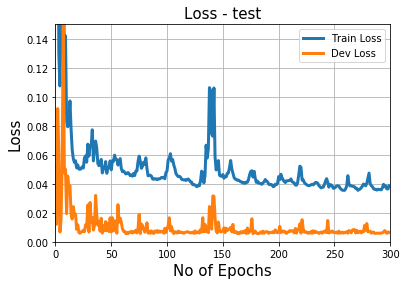

Training Set Score: 0.7573
Dev Set Score: -0.5120
Test Set Score: -3.7363
Training Set MSE: 2349992459.4989
Dev Set MSE: 127816110.9362
Test Set MSE: 49000418.7654


In [18]:
def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()


plot_loss(history_LSTM, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)


In [19]:
def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction):
    flow_type = {0: "Actual oil rate",
                1: "Actual gas rate",
                2: "Actual water rate"}
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label=flow_type[i])

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well ", y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)


In [20]:
t = pd.DataFrame(np.arange(len(df)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


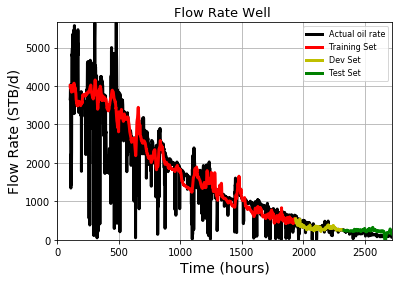

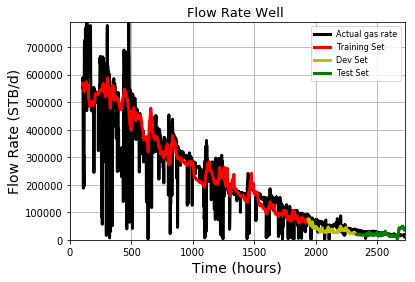

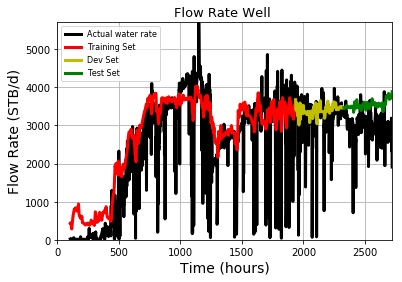

In [21]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=val_fraction, test_fraction=test_fraction)

In [22]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
py.init_notebook_mode(connected = True)

In [23]:
def plot_iterative_flow(t, q_actual, q_pred, val_fraction, test_fraction):
	lowrate_type = {0:"Actual oil rate",
					 1: "Actual gas rate",
					 2: "Actual water rate"}
	trace1 = go.Scatter(x = t,
						y = q_actual,
						name = lowrate_type[i])
	train_tail = int((1 -val_fraction - test_fraction) * q_pred.shape[0])
	trace2 = go.Scatter(x = t[0:train_tail],
						y = q_pred[0:train_tail],
						name = "Training set")

	val_tail = int((1-test_fraction) * q_pred.shape[0])
	trace3 = go.Scatter(x = t[train_tail:val_tail],
						y = q_pred[train_tail:val_tail],
						name = "Val set")
	trace4 = go.Scatter(x = t[val_tail:],
						y = q_pred[val_tail:],
						name = "Test set")
	data = [trace1, trace2, trace3, trace4]
	layout = {"title": "Flow rate well"}
	fig = go.Figure(data = data, layout = layout)
	py.iplot(fig)

In [24]:
t = np.arange(len(df))
for i in range(y_act.shape[1]):
    plot_iterative_flow(t,
                   y_act[:, i], y_pred[:, i], val_fraction=val_fraction, test_fraction=test_fraction)


In [25]:
S = 0
cum = []
for i in y_pred_train[:,0]:
    S = S + i
    cum.append(S)
for i in y_pred_dev[:,0]:
    S+= i
    cum.append(S)
for i in y_pred_test[:,0]:
    S+= i
    cum.append(S)
    
T = 0
re = []
for i in y_train_act[:,0]:
    T += i
    re.append(T)
for i in y_dev_act[:,0]:
    T += i
    re.append(T)
for i in y_test_act[:,0]:
    T += i
    re.append(T)
a = np.asarray(cum)
b = np.asarray(re)

In [26]:
#trace1 = go.Scatter(x = np.arange(len(a)),
#                    y = a.reshape(-1,),
#                   name = "Prediction")
#trace2 = go.Scatter(x = np.arange(len(a)),
 #                   y = b.reshape(-1,),
  #                 name = "Actual values")
#data = [trace1, trace2]
#layout = go.Layout(title = "Cummulative oil production of Long short term memory")
#fig = go.Figure(data = data, layout = layout)
#py.iplot(fig)

In [27]:
S = 0
cum = []
for i in y_pred_train[:,1]:
    S = S + i
    cum.append(S)
for i in y_pred_dev[:,1]:
    S+= i
    cum.append(S)
for i in y_pred_test[:,1]:
    S+= i
    cum.append(S)
    
T = 0
re = []
for i in y_train_act[:,1]:
    T += i
    re.append(T)
for i in y_dev_act[:,1]:
    T += i
    re.append(T)
for i in y_test_act[:,1]:
    T += i
    re.append(T)
    
a = np.asarray(cum)
b = np.asarray(re)

In [28]:
#trace1 = go.Scatter(x = np.arange(len(a)),
#                    y = a.reshape(-1,),
        #           name = "Prediction")
#trace2 = go.Scatter(x = np.arange(len(a)),
#                    y = b.reshape(-1,),
#                   name = "Actual values")
#data = [trace1, trace2]
#layout = go.Layout(title = "Cummulative gas production of Long short term memory")
#fig = go.Figure(data = data, layout = layout)
#py.iplot(fig)

In [29]:
S = 0
cum = []
for i in y_pred_train[:,2]:
    S = S + i
    cum.append(S)
for i in y_pred_dev[:,2]:
    S+= i
    cum.append(S)
for i in y_pred_test[:,2]:
    S+= i
    cum.append(S)
    
T = 0
re = []
for i in y_train_act[:,2]:
    T += i
    re.append(T)
for i in y_dev_act[:,2]:
    T += i
    re.append(T)
for i in y_test_act[:,2]:
    T += i
    re.append(T)
    
a = np.asarray(cum)
b = np.asarray(re)

In [30]:
#trace1 = go.Scatter(x = np.arange(len(a)),
   #                 y = a.reshape(-1,),
   #                name = "Prediction")
#trace2 = go.Scatter(x = np.arange(len(a)),
                    y = b.reshape(-1,),
#                   name = "Actual values")
#data = [trace1, trace2]
#layout = go.Layout(title = "Cummulative water production of Long short term memory")
#fig = go.Figure(data = data, layout = layout)
#py.iplot(fig)

In [31]:
output = np.concatenate((y_pred_train, y_pred_dev, y_pred_test), axis = 0)

In [32]:
output.shape

(2618, 3)

In [33]:
output = pd.DataFrame(output)

In [34]:
output.to_csv("F14out.csv")

In [36]:
model_json = model_LSTM.to_json()
with open("model_LSTM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_LSTM.save_weights("model.h5")